In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [3]:
tf.__version__


'1.8.0'

In [4]:
# convolution layer
# layer 1
filter_size1=5 
num_filter1= 16
# layer 2
filter_size2= 5
num_filter2= 36
fc_size= 128 # number of fully connected neurons

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
data.test.cls= np.argmax(data.test.labels,axis= 1)

In [7]:
# Data  dimensions
img_size= 28 # 28 pixels image
# images are stored in 1d Array of this length
img_size_flat= img_size * img_size

#Tuple with height and width of image is used to reshape arrays
img_shape = (img_size,img_size)

# number of channels (colors for input image) for grayscale 1
num_channels= 1
# number of class [0,1...9]
num_classes= 10

In [8]:
# function for plotting images
def plot_images(images,cls_true,cls_pred= None):
    assert len(images)== len(cls_true)== 9
  
    # create with 3X3 subplot 
    fig,axes= plt.subplots(3,3)
    fig.subplots_adjust(hspace= 0.3,wspace= 0.3)
    
    for i,ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(img_shape),cmap= 'binary')
        # Show true and predicted class
        if cls_pred is None:
            xlabel ="True: {0}".format(cls_true[i])
        else:
             xlabel ="True: {0},  Pred: {1}".format(cls_true[i],cls_pred[i])
        
        ax.set_xlabel(xlabel)
        # remove ticks form plot
        ax.set_xticks([])
        ax.set_yticks([])
            
    plt.show()

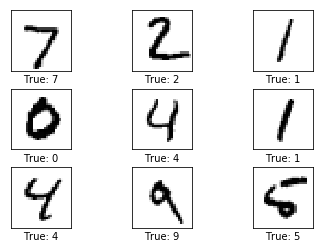

In [9]:
images= data.test.images[0:9]
cls_true= data.test.cls[0:9]
plot_images(images= images,cls_true= cls_true)

In [10]:
# helper functions for creating new variables
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev= 0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape= [length]))

In [11]:
# we create a separate fuction for convolution layer
# it is assumed it is 4 dimensional input( image number,X- axis, Y- axis,channels)
# output is also 4 dimentional output(image number,X,Y,channel for each convolutional filter)


In [12]:
def new_conv_layer(input, # previous layer
                   num_input_channels, # number of channels in previous layer
                  filter_size, # widthXHeight of each filter
                  num_filters, # number of filter
                  use_pooling= True): # use 2X2 max_pooling
    #shape of the filter-weight for the convolution
     # format determined by tf API
        shape= [filter_size,filter_size,num_input_channels,num_filters]
        weights= new_weights(shape = shape)
        biases= new_biases(length= num_filters)
        # create tensorflow operation
        layer= tf.nn.conv2d(input= input,filter= weights,strides= [1,1,1,1],padding= 'SAME')
        # add biases to images
        layer+= biases
        
        if use_pooling:
            layer= tf.nn.max_pool(value= layer,ksize= [1,2,2,1],strides= [1,2,2,1],padding= 'SAME')
            
        layer= tf.nn.relu(layer)
        
        return layer,weights
            
        

In [13]:
# Helper function for flattering layer
def flatten_layer(layer):
    layer_shape= layer.get_shape()
    num_features= np.array(layer_shape[1:4],dtype= int).prod()
    layer_flat= tf.reshape(layer,[-1,num_features])
    
    return layer_flat,num_features

In [14]:
# Helper function for new Fully connected layer
def new_fc_layer(input,# previous layer
                 num_inputs,# number of inputs of previous layer
                num_outputs, # no. of outputs,
                use_relu= True):
    weights= new_weights(shape= [num_inputs,num_outputs])
    biases = new_biases(length= num_outputs)
    layer= tf.matmul(input,weights)+ biases
    
    if use_relu:
        layer= tf.nn.relu(layer)
    return layer

In [15]:
# placehoder variable to change input to computational graph
x= tf.placeholder(tf.float32,shape= [None,img_size_flat],name= 'x')
# however we (convolution layer)expect it to be encoded as 4d 
x_image= tf.reshape(x,[-1,img_size,img_size,num_channels])
# on hot encoded vector
y_true= tf.placeholder(tf.float32,shape= [None,10],name= 'y_true')

y_true_cls= tf.argmax(y_true,dimension= 1)


Instructions for updating:
Use the `axis` argument instead


In [16]:
# 1st conv layer
layer_conv1,weights_conv1 =  \
    new_conv_layer(input= x_image,
                  num_input_channels= num_channels,
                   filter_size= filter_size1,
                  num_filters= num_filter1,
                  use_pooling= True)


In [17]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [18]:
# second convolutional layer
layer_conv2, weights_conv2 = \
new_conv_layer(input= layer_conv1,
              num_input_channels= num_filter1,
               filter_size= filter_size2,
              num_filters= num_filter2,
              use_pooling= True)

In [19]:
layer_conv2


<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [20]:
layer_flat,num_features= flatten_layer(layer_conv2)

In [21]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [22]:
# make fully connectd layer
layer_fc1= new_fc_layer(input= layer_flat,
                       num_inputs= num_features,
                        num_outputs= fc_size,
                        use_relu= True)


In [23]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [24]:
# Add another fully connected layer
layer_fc2= new_fc_layer(input= layer_fc1,
                        num_inputs= fc_size,
                       num_outputs= num_classes,
                       use_relu= False)

In [25]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [26]:
# prediction
y_pred= tf.nn.softmax(layer_fc2)

In [27]:
y_pred_cls= tf.argmax(y_pred,dimension=1)

In [28]:
cross_entropy= tf.nn.softmax_cross_entropy_with_logits(logits= layer_fc2,labels= y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [29]:
cost = tf.reduce_mean(cross_entropy)

In [30]:
# Optimization
optimizer= tf.train.AdamOptimizer(learning_rate= 1e-4).minimize(cost)


In [31]:
# Performance measure
correct_prediction= tf.equal(y_pred_cls,y_true_cls)

In [32]:
# casting boolean to float
accuracy= tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [33]:
# Tensorflow run

In [34]:
session= tf.Session()

In [35]:
session.run(tf.global_variables_initializer())


In [36]:
train_batch_size= 64

In [37]:
total_iterations= 0
def optimize(num_iterations):
    global total_iterations
    start_time= time.time()
    for i in range(total_iterations, 
                   total_iterations+ num_iterations):
        x_batch,y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train= {x: x_batch,y_true: y_true_batch}
        
        session.run(optimizer,feed_dict= feed_dict_train)
        # for every 100 iterations we print the progress
        if i%100  == 0:
            acc= session.run(accuracy,feed_dict= feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
    total_iterations+= num_iterations
    #Ending time
    end_time= time.time()
    time_dif= end_time- start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    

In [38]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [39]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [40]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [41]:
# initial Accuracy
print_test_accuracy()

Accuracy on Test-Set: 10.0% (1002 / 10000)


In [42]:
# performance after 1 optimization
optimize(num_iterations= 1)


Optimization Iteration:      1, Training Accuracy:   4.7%
Time usage: 0:00:01


In [43]:
print_test_accuracy()

Accuracy on Test-Set: 7.3% (728 / 10000)


In [44]:
optimize(num_iterations= 99)

Time usage: 0:00:06


Accuracy on Test-Set: 64.5% (6452 / 10000)
Example errors:


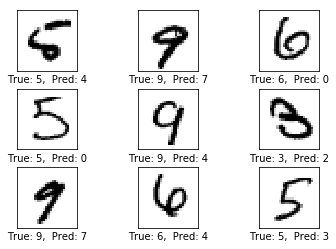

In [45]:
print_test_accuracy(show_example_errors= True)

In [46]:
optimize(num_iterations= 900)

Optimization Iteration:    101, Training Accuracy:  59.4%
Optimization Iteration:    201, Training Accuracy:  82.8%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  84.4%
Optimization Iteration:    501, Training Accuracy:  79.7%
Optimization Iteration:    601, Training Accuracy:  90.6%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  96.9%
Optimization Iteration:    901, Training Accuracy:  89.1%
Time usage: 0:00:53


Accuracy on Test-Set: 93.5% (9346 / 10000)
Example errors:


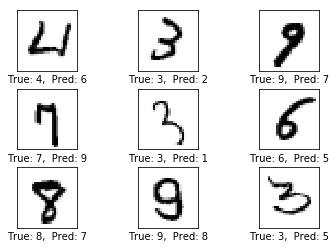

In [47]:
print_test_accuracy(show_example_errors= True)

In [48]:
optimize(num_iterations= 9000)

Optimization Iteration:   1001, Training Accuracy:  85.9%
Optimization Iteration:   1101, Training Accuracy:  92.2%
Optimization Iteration:   1201, Training Accuracy:  89.1%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  93.8%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  93.8%
Optimization Iteration:   1701, Training Accuracy:  93.8%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  98.4%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy:  95.3%
Optimization Iteration:   2501, Training Accuracy:  98.4%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I